In [1]:
import cv2
import io
import numpy as np
import pylab as plt
import skimage.data
import skimage.transform
import torch
from torch.nn.functional import pad


import shapes_generation
from simulator import IdealB0Generator, SliceBlochSimulator2, gyromagnetic_ratio
from skimage.transform.radon_transform import _get_fourier_filter

plt.style.use('dark_background')

In [2]:
def add_zero(x):
    return pad(x, (1, 0))

def minmax_scale(x):
    return 2 * (x - x.min()) / (x.max() - x.min()) - 1.

In [3]:
def get_random_shape(size=(64, 64), n_points=7, center=(0., 0.), scale=1.):
    fig, _ = plt.subplots(figsize=(10, 10), dpi=90)

    a = shapes_generation.get_random_points(n=n_points, scale=1.)
    x, y, _ = shapes_generation.get_bezier_curve(a - a.mean(0, keepdims=True), rad=0.5, edgy=0.01)
    x, y = minmax_scale(x), minmax_scale(y)
    plt.fill_between(x, np.zeros_like(y), y, facecolor='w')

    plt.xlim((-1. - center[0]) / scale, (1. - center[0]) / scale)
    plt.ylim((-1. - center[1]) / scale, (1. - center[1]) / scale)

    plt.axis('off')
    io_buf = io.BytesIO()
    plt.tight_layout()
    fig.savefig(io_buf, format='raw')
    io_buf.seek(0)
    img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                        newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    img = torch.from_numpy(cv2.resize(img_arr[:,:,0], size)).float()
    io_buf.close()
    plt.close()
    return img

def generate_phantom_mask(n_shapes, complexity=8, size=(64, 64), center_range=(-0.4, 0.4), scale_range=(.4, .8)):
    shapes = torch.stack([torch.zeros(size)] + [
        get_random_shape(size, n_points=complexity,
            center=np.random.uniform(*center_range, 2),
            scale=np.random.uniform(*scale_range)
        ) / 255 for _ in range(n_shapes)
    ])
    mask = shapes.cumsum(0).argmax(0)
    return mask

def get_values(n_shapes, pd_range=(0, 255), t1_range=(1., 5.), t2_range=(2., 7.)):
    pd = add_zero(torch.randint(*pd_range, (n_shapes,))).float()
    t1 = add_zero(torch.tensor(np.random.uniform(*t1_range, n_shapes))).float()
    t2 = add_zero(torch.tensor(np.random.uniform(*t2_range, n_shapes))).float()
    return pd, t1, t2

def sort_classes(mask):
    order = mask.flatten().bincount().argsort(descending=True)
    return order.argsort()[mask]

In [4]:
size = (64, 64)

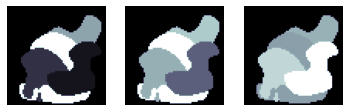

In [5]:
#!L
plt.style.use('dark_background')
mask = generate_phantom_mask(4, size=size)
pd, t1, t2 = get_values(4)

plt.subplot(131)
plt.imshow(pd[mask], cmap=plt.cm.bone)
plt.axis('off')
plt.subplot(132)
plt.imshow(t1[mask], cmap=plt.cm.bone)
plt.axis('off')
plt.subplot(133)
plt.imshow(t2[mask], cmap=plt.cm.bone)
plt.axis('off')
plt.show()

100%|██████████| 26/26 [00:00<00:00, 4667.52it/s]


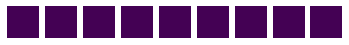

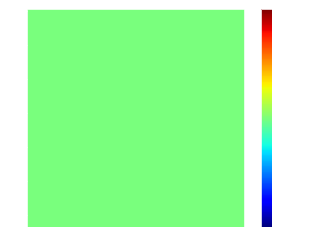

In [6]:
angles = torch.arange(0, 360, step=14)
field_generator = IdealB0Generator(torch.device('cpu'), angles, size, mean=190., std=4.)
B_grad_plus = field_generator()
field_generator = IdealB0Generator(torch.device('cpu'), angles + 180, size, mean=190., std=4.)
B_grad_negative = field_generator()
B0 = torch.ones_like(B_grad_plus) * 190
B0[:, :2] = 0

B1 = torch.stack([torch.ones(size) * 0.525, torch.zeros(size), torch.zeros(size)])

for i, _B0 in enumerate(B0[:9, 2]):
    plt.subplot(int(f'19{i+1}'))
    plt.imshow(_B0)
    plt.axis('off')
plt.show()

plt.imshow(B0[0, 2] * gyromagnetic_ratio, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

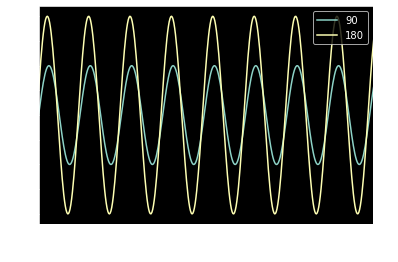

In [7]:
pulse90_time = torch.linspace(0, 0.0235, 10000)
pulse90 = torch.sin(2 * np.pi * pulse90_time * 190 * gyromagnetic_ratio)
pulse180_time = torch.linspace(0.2, 0.2235, 10000)
pulse180 = 2 * torch.sin(2 * np.pi * pulse180_time * 190 * gyromagnetic_ratio)
pulse180_v = [pulse180.clone() for _ in range(8)]


plt.plot(pulse90_time, pulse90, label='90')
plt.plot(pulse180_time - 0.2, pulse180, label='180')
plt.xlim(0, 0.001)
plt.legend()
plt.xlabel('ms')
plt.show()

In [8]:
rf_sequence = [
    dict(field=B1, pulse=pulse90, t=pulse90_time, desc='p90', device=0),
    *[
        dict(field=B1, pulse=pulse180_v[i], t=pulse180_time + 0.4 * i, desc=f'p180_{i}', device=0)
        for i in range(8)
    ]
]

grad_sequence = [
    [
        dict(field=B_grad_negative, t=[0.2235 + 0.4 * i, 0.2935 + 0.4 * i], desc=f'G-_{i}', device=0),
        dict(field=B_grad_plus, t=[0.33 + 0.4 * i, 0.47 + 0.4 * i], desc=f'G+_{i}', device=0),
        dict(field=B_grad_negative, t=[0.5065 + 0.4 * i, 0.5765 + 0.4 * i], desc=f'G-_{i}', device=0),
    ]
    for i in range(8)
]
grad_sequence = [v for s in grad_sequence for v in s]

read_sequence = [
    dict(t=[0.37 + 0.4 * i, 0.42 + 0.4 * i], desc='readout')
    for i in range(8)
]

timespaces = [
    torch.arange(-0.05, 0.0, 12e-4)[:-1],       # wait
    torch.arange(0.0, 0.0235, 24e-6)[:-1],      # pulse90
    torch.arange(0.0235, 0.2, 12e-4)[:-1],      # wait
]
add_timespaces = [
    [
        torch.arange(0.2 + 0.4 * i, 0.2235 + 0.4 * i, 24e-6)[:-1],      # pulse180
        torch.arange(0.2235 + 0.4 * i, 0.37 + 0.4 * i, 12e-4)[:-1],     # wait
        torch.arange(0.37 + 0.4 * i, 0.42 + 0.4 * i, 24e-6)[:-1],       # read
        torch.arange(0.42 + 0.4 * i, 0.6 + 0.4 * i, 12e-4)[:-1],        # wait
    ]
    for i in range(8)
]
add_timespaces = [v for s in add_timespaces for v in s]
timespaces = timespaces + add_timespaces
timespace = torch.cat(timespaces)
# timespace = torch.linspace(timespace[0], timespace[-1], 60000)
print(f'timesteps: {len(timespace)}')

timesteps: 27836


In [9]:
read_times = [
    [0.31 + 0.4 * i, 0.47 + 0.4 * i]
    for i in range(8)
]

In [10]:
#!L
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [11]:
#!L
def get_art_recon(simulator, M, t1, t2, res):
    angle_step = 1
    time_step = 1
    angles = simulator.angles[::angle_step]
    B0_readout = B_grad_plus[::angle_step, :, ::1, ::1]
    IH, IW = B0_readout.shape[-2:]
    target_H = res

    SE_t = simulator.timespace\
    [(simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()]\
    [M[:,1].cpu().abs()[
            :,
            (simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()
        ].mean(0).argmax()
    ].item()

    t1 = SE_t - target_H / ((B0_readout[:, 2].max() - B0_readout[:, 2].min()) * gyromagnetic_ratio)
    t2 = SE_t + target_H / ((B0_readout[:, 2].max() - B0_readout[:, 2].min()) * gyromagnetic_ratio)

    time = simulator.timespace[(simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()].cpu()[::time_step]
    se_data = M[:,1][:, (simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()].cpu()[::angle_step, ::time_step]

    se = se_data * (-2j * np.pi * B0_readout[:, 2, IH//2, IW//2][:, None] * gyromagnetic_ratio * (time[None] - SE_t)).exp()
    baseband = torch.fft.ifftshift(torch.fft.fft(se, dim=-1), dim=-1)
    freq = torch.fft.ifftshift(torch.fft.fftfreq(se.shape[1], d=(time[-1] - time[0]) / time.shape[0]))

    baseband[:, :baseband.shape[-1]//2 - target_H] = 0
    baseband[:, baseband.shape[-1]//2 + target_H:] = 0

    baseband = baseband[:, baseband.shape[-1]//2 - target_H:baseband.shape[-1]//2 + target_H].abs()
    freq = freq[baseband.shape[-1]//2 - target_H:baseband.shape[-1]//2 + target_H]
    se_down = torch.fft.fft(torch.fft.ifftshift(baseband, dim=-1), dim=-1)
    se_down = torch.fft.ifftshift(se_down, dim=-1)
    time = torch.nn.functional.interpolate(time[None, None], size=[se_down.shape[-1]])[0,0]

    E = torch.zeros([angles.shape[0], time.shape[0], IH*IW]).cfloat()
    for i, theta in enumerate(angles):
        E[i] = torch.exp(1j * 2 * np.pi * ((-B0_readout[i][2].flatten() + B0_readout[i, 2, IH//2, IW//2]) * gyromagnetic_ratio)[None] * (time - SE_t)[:, None]).cfloat()
    E = E.to(device)

    m_old = torch.zeros((IH, IW)).view(-1, 1).cfloat()
    m_old = m_old.to(device)
    _se_data = se_down.to(device)

    for i in range(1000):
        update = (((_se_data.roll(0,0) - (E @ m_old.cfloat())[:, :, 0]) / E.norm(p=2, dim=2))[:, None] * E.transpose(1, 2).conj()).mean([0,2]).view(-1, 1)
        m_old = m_old + 5e-2 * update

    rimg = m_old.reshape(IH, IW).abs()
    return rimg

In [12]:
def get_art_recon2(simulator, M, t1, t2, res):
    angle_step = 1
    time_step = 1
    angles = simulator.angles[::angle_step]
    B0_readout = B_grad_plus[::angle_step, :, ::1, ::1]
    IH, IW = B0_readout.shape[-2:]
    target_H = res # ask Artem!
    #taking time SE_t when y-th projection is maximal for time in [t1;t2]
    t1_idx = (simulator.timespace - t1).abs().argmin()
    t2_idx = (simulator.timespace - t2).abs().argmin()
    SE_t = simulator.timespace[t1_idx:t2_idx][M[:,1].cpu().abs()[:,t1_idx:t2_idx].mean(0).argmax()].item()
    # normalize? t1 and t2 (why do we use only z-th component of B?), ti is border of (SE_t-res; SE_t + res) 
    # ask Artem why we should normalize in this way?
    t1 = SE_t - target_H / ((B0_readout[:, 2].max() - B0_readout[:, 2].min()) * gyromagnetic_ratio)
    t2 = SE_t + target_H / ((B0_readout[:, 2].max() - B0_readout[:, 2].min()) * gyromagnetic_ratio)
    print(t1, t2)
    
    t1_idx = (simulator.timespace - t1).abs().argmin()
    t2_idx = (simulator.timespace - t2).abs().argmin()
    
    time = simulator.timespace[t1_idx:t2_idx].cpu()[::time_step]
    se_data = M[:,1][:, t1_idx:t2_idx].cpu()[::angle_step, ::time_step]
    
    # wut?
    se = se_data * (-2j * torch.pi * B0_readout[:, 2, IH//2, IW//2][:, None] * gyromagnetic_ratio * (time[None] - SE_t)).exp()
    # ifftshift -> fftshift
    baseband = torch.fft.fftshift(torch.fft.fft(se, dim = -1), dim = -1)
    freq = torch.fft.fftshift(torch.fft.fftfreq(se.shape[1], d = (time[-1] - time[0]) / time.shape[0]))
    # filtering only remain A from freq in [baseband.shape[-1]//2 - target_H; baseband.shape[-1]//2 + target_H]
    left_border = baseband.shape[-1]//2 - target_H
    right_border = baseband.shape[-1]//2 + target_H

    baseband[:, :left_border] = 0
    baseband[:, right_border:] = 0

    baseband = baseband[:, left_border:right_border].abs()
    freq = freq[left_border:right_border]
    # ask artem about this line! Why not conventient ifft from f domain to t domain?
    se_down = torch.fft.ifft(torch.fft.ifftshift(baseband, dim = -1), dim = -1)
    se_down = torch.fft.fftshift(se_down, dim = -1) 

    time = torch.nn.functional.interpolate(time[None, None], size=[se_down.shape[-1]]).squeeze()
    E = torch.zeros([angles.shape[0], time.shape[0], IH*IW]).cfloat()
    # wut?
    for i, theta in enumerate(angles):
        E[i] = torch.exp(1j * 2 * torch.pi * ((-B0_readout[i][2].flatten() + B0_readout[i, 2, IH//2, IW//2]) * gyromagnetic_ratio)[None] * (time - SE_t)[:, None]).cfloat()
    E = E.to(device)

    m_old = torch.zeros((IH, IW)).view(-1, 1).cfloat()
    m_old = m_old.to(device)
    _se_data = se_down.to(device)
    
    # art
    for i in range(1000):
        update = (((_se_data - (E @ m_old.cfloat()).squeeze()) / E.norm(p=2, dim=2))[:, None] * E.transpose(1, 2).conj()).mean([0,2]).view(-1, 1)
        m_old = m_old + 5e-2 * update

    rimg = m_old.reshape(IH, IW).abs()
    return rimg

In [14]:
#!L
def get_simulated_images(pd, t1, t2):
    simulator = SliceBlochSimulator2(
        device=device, num_isochromats_per_voxel=4, 
        isOffsetStatic=True, mstd=0, offsetHz=0,
        rho_map=pd, t1_map=t1, t2_map=t2,
        angles=angles, B0=B0,
        rf_sequence=rf_sequence,
        grad_sequence=grad_sequence,
        read_sequence=read_sequence,
        timespace=timespace
    )

    M = simulator.simulate(verbose=True)
    simulator.timespace = simulator.timespace[1:]
    
    vec_img = []
    vec_time = []
    for t1_time, t2_time in read_times:
        rimg = get_art_recon2(simulator, M, t1_time, t2_time, res=16)
        vec_img.append(rimg)
        vec_time.append((t2_time + t1_time) / 2)
    vec_img = torch.stack(vec_img)
    vec_time = torch.tensor(vec_time)
    
    A = torch.vander(vec_time.cpu(), N=2)
    b = vec_img.view(-1, np.prod(size)).cpu().detach().log()
    emap = - 1 / ((A.T @ A).pinverse() @ A.T @ b)[0].reshape(size)
    emap = torch.nan_to_num(emap, 0.0)
    emap[emap < 0.5] = 0
    emap[emap > 10.0] = 0
    return vec_img.cpu(), emap

In [15]:
mask = generate_phantom_mask(4, size=size)
pd, t1, t2 = get_values(4)
mask = sort_classes(mask)


In [17]:
vec_img, emap2 = get_simulated_images(pd[mask], t1[mask], t2[mask])

100%|██████████| 27835/27835 [01:58<00:00, 235.24it/s]                 


tensor(0.3792) tensor(0.4182)
tensor(0.7802) tensor(0.8191)
tensor(1.1792) tensor(1.2182)
tensor(1.5802) tensor(1.6191)
tensor(1.9793) tensor(2.0183)
tensor(2.3802) tensor(2.4191)
tensor(2.7793) tensor(2.8183)
tensor(3.1801) tensor(3.2191)


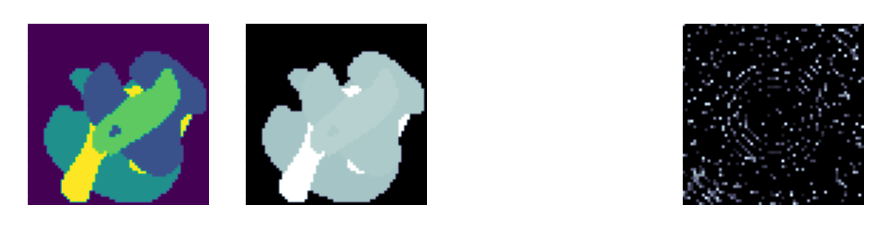

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1, title="Mask").imshow(mask)
plt.subplot(1, 4, 2, title="True T2").imshow(t2[mask], cmap=plt.cm.bone)
# plt.subplot(1, 4, 3, title="Reference").imshow(emap, cmap=plt.cm.bone)
plt.subplot(1, 4, 4, title="Test").imshow(emap2, cmap=plt.cm.bone)

In [18]:
#!L
from tqdm import trange

batch_size = 100
n_batches = 2

pd, t1, t2 = get_values(4)

for i in range(n_batches):
    batch = {"mask": [], "pd": pd, "t1": t1, "t2": t2, "slices": [], "reconstruct": []}

    for _ in trange(batch_size):
        plt.style.use('dark_background')
        mask = generate_phantom_mask(4, size=size)
        mask = sort_classes(mask)
        vec_img, emap = get_simulated_images(pd[mask], t1[mask], t2[mask])
        batch["mask"].append(mask)
        # batch["pd"].append(pd)
        # batch["t1"].append(t1)
        # batch["t2"].append(t2)
        batch["slices"].append(vec_img)
        batch["reconstruct"].append(emap)
    
    torch.save(batch, f"data/batch{i}.dat")

  0%|          | 0/100 [00:00<?, ?it/s]/home/nekrashevich/bsim/simulator.py:268: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  return R.T
  0%|          | 0/100 [01:12<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'append'